In [4]:
import matplotlib
import matplotlib.pyplot as plt

import pandas as pd
pd.set_option('display.max_columns', 500)
pd.options.mode.chained_assignment = None
plt.rcParams["figure.figsize"] = (35,7)

from sklearn.cluster import MiniBatchKMeans, DBSCAN
from sklearn.preprocessing import StandardScaler

import numpy as np

In [5]:
def read_data(filename, cols_to_read, rows_to_read):
    
    if cols_to_read is None:
        df = pd.read_csv(filename).fillna(method='ffill')
    else:
        df = pd.read_csv(filename, usecols=cols_to_read).fillna(method='ffill')
    
    return df.iloc[rows_to_read]

In [6]:
def clean_data(data):
    data.dropna(inplace=True)
    data.drop(data[data['ITF.BCT15:CURRENT'] < 0].index, inplace=True)
    data.drop(data[data['ITF.BCT25:CURRENT'] < 0].index, inplace=True)
    data.drop(data[data['ITH.BCT41:CURRENT'] < 0].index, inplace=True)
    data.drop(data[data['ITL.BCT05:CURRENT'] < 0].index, inplace=True)
    data.drop(data[data['IP.NSRCGEN:OVEN1AQNP'] < 4.5].index, inplace=True)
    data.drop(data[data['IP.SOLEXT.ACQUISITION:CURRENT'] < 1200].index, inplace=True)
    data.drop(data[data['IP.NSRCGEN:BIASDISCAQNV'] == 0].index, inplace=True)
    data.drop(data[data['IP.SAIREM2:FORWARDPOWER'] < 500].index, inplace=True)
    data.drop(data[data['IP.NSRCGEN:SOURCEHTAQNI'] > 2.5].index, inplace=True)
    data.drop(data[data['IP.NSRCGEN:SOURCEHTAQNI'] < 0.5].index, inplace=True)

In [7]:
current_mean_min = 0.025
current_var_max = 0.0001
sliding_window_size = int(100*60/1.2)

def is_source_stable(mean, var):
    if mean == float('NaN') or var == float('NaN'):
        return ''
    return 1 if mean > current_mean_min and var < current_var_max else 0

In [8]:
data_raw_file = '../Data_Raw/Nov2018.csv'

In [9]:
cols_to_read = ['Timestamp (UTC_TIME)', 'IP.NSRCGEN:BIASDISCAQNV', 'IP.NSRCGEN:GASSASAQN', 'ITF.BCT25:CURRENT', 'IP.SOLCEN.ACQUISITION:CURRENT']
rows_to_read = list(range(500000, 1500000))
df = read_data(data_raw_file, None, rows_to_read)

In [10]:
clean_data(df)
df = df[cols_to_read]

In [11]:
df['ITF.BCT25:CURRENT_MEAN'] = df['ITF.BCT25:CURRENT'].rolling(sliding_window_size).mean()
df['ITF.BCT25:CURRENT_VAR'] = df['ITF.BCT25:CURRENT'].rolling(sliding_window_size).var()
df.head()

,Timestamp (UTC_TIME),IP.NSRCGEN:BIASDISCAQNV,IP.NSRCGEN:GASSASAQN,ITF.BCT25:CURRENT,IP.SOLCEN.ACQUISITION:CURRENT,ITF.BCT25:CURRENT_MEAN,ITF.BCT25:CURRENT_VAR
500000,2018-11-07 16:41:59.255,-258.0,5.192,0.0297,220.01,NaN,NaN
500001,2018-11-07 16:42:00.041,-258.0,5.192,0.0297,220.01,NaN,NaN
500002,2018-11-07 16:42:01.041,-258.0,5.192,0.0297,220.01,NaN,NaN
500003,2018-11-07 16:42:01.655,-258.0,5.192,0.0297,220.01,NaN,NaN
500004,2018-11-07 16:42:03.041,-258.0,5.192,0.0297,220.01,NaN,NaN


In [12]:
df['IS_STABLE'] = df.apply(lambda row: is_source_stable(row['ITF.BCT25:CURRENT_MEAN'], row['ITF.BCT25:CURRENT_VAR']), axis=1)

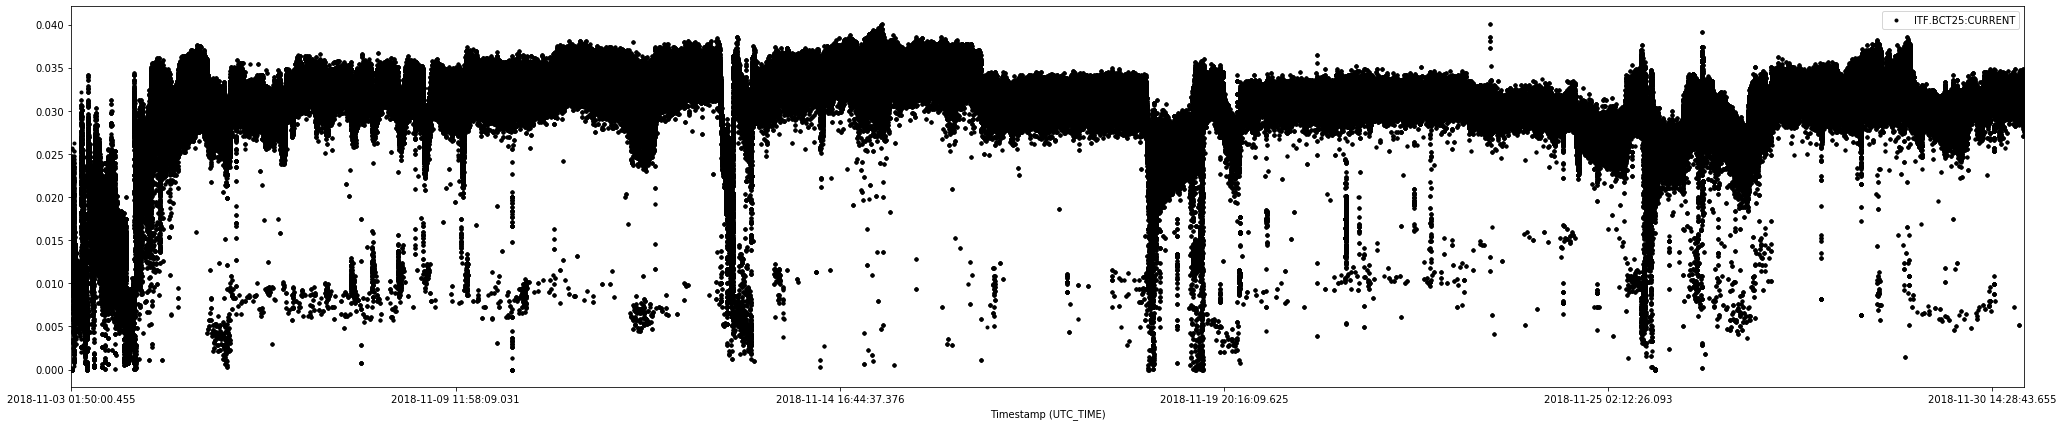

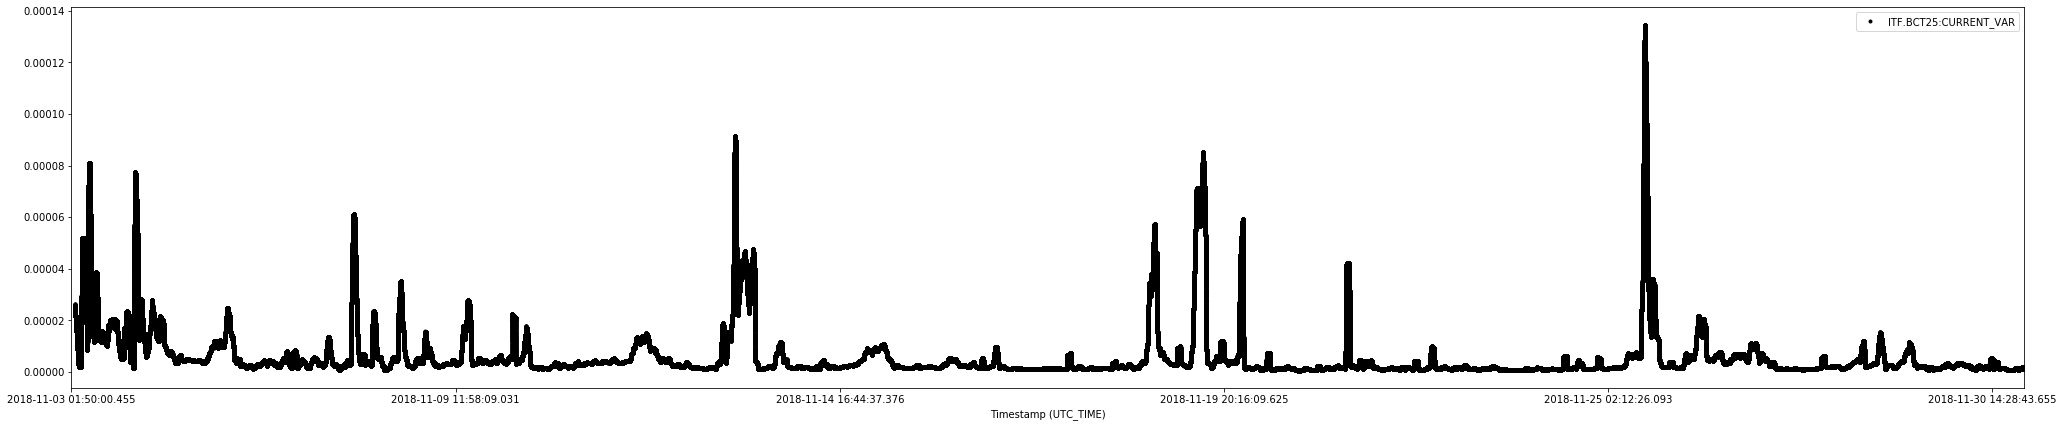

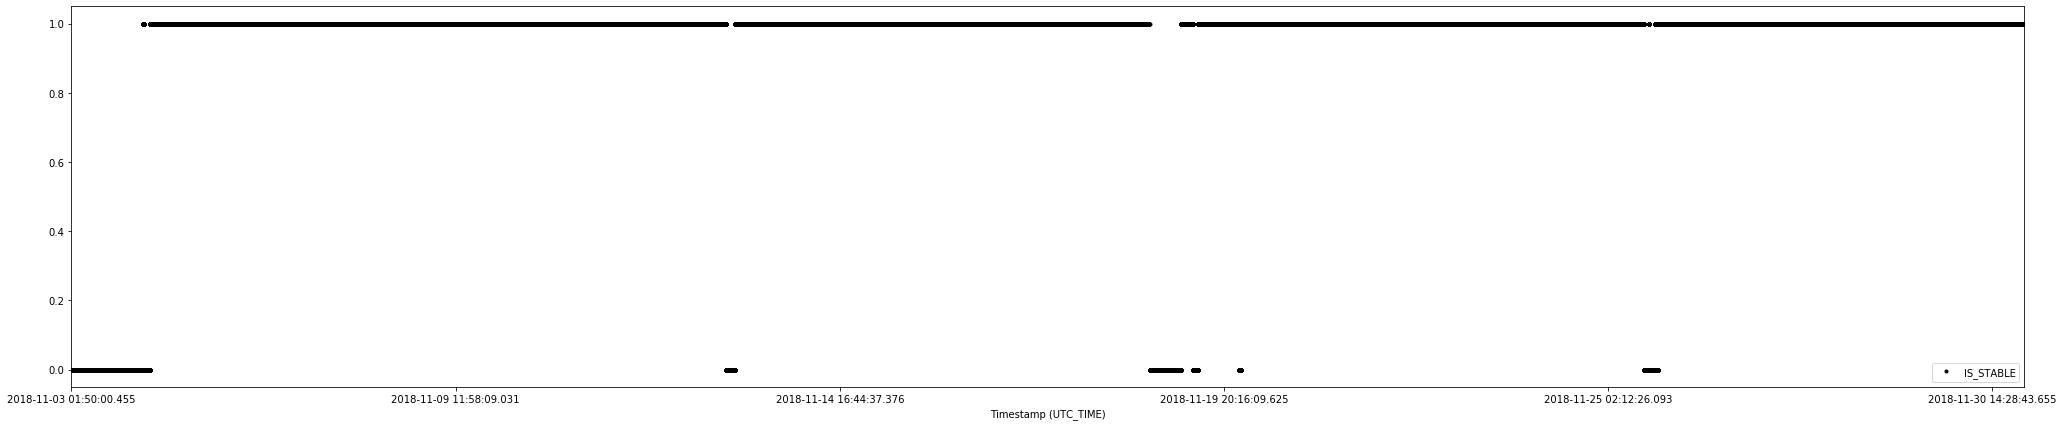

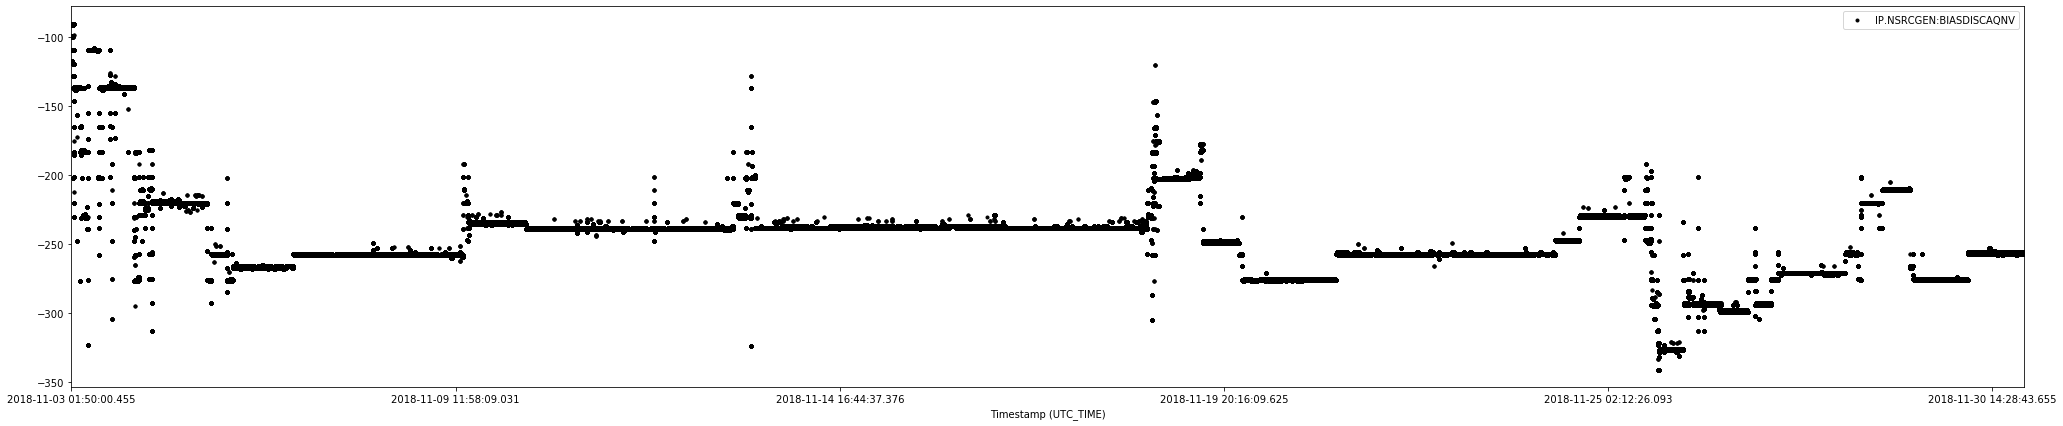

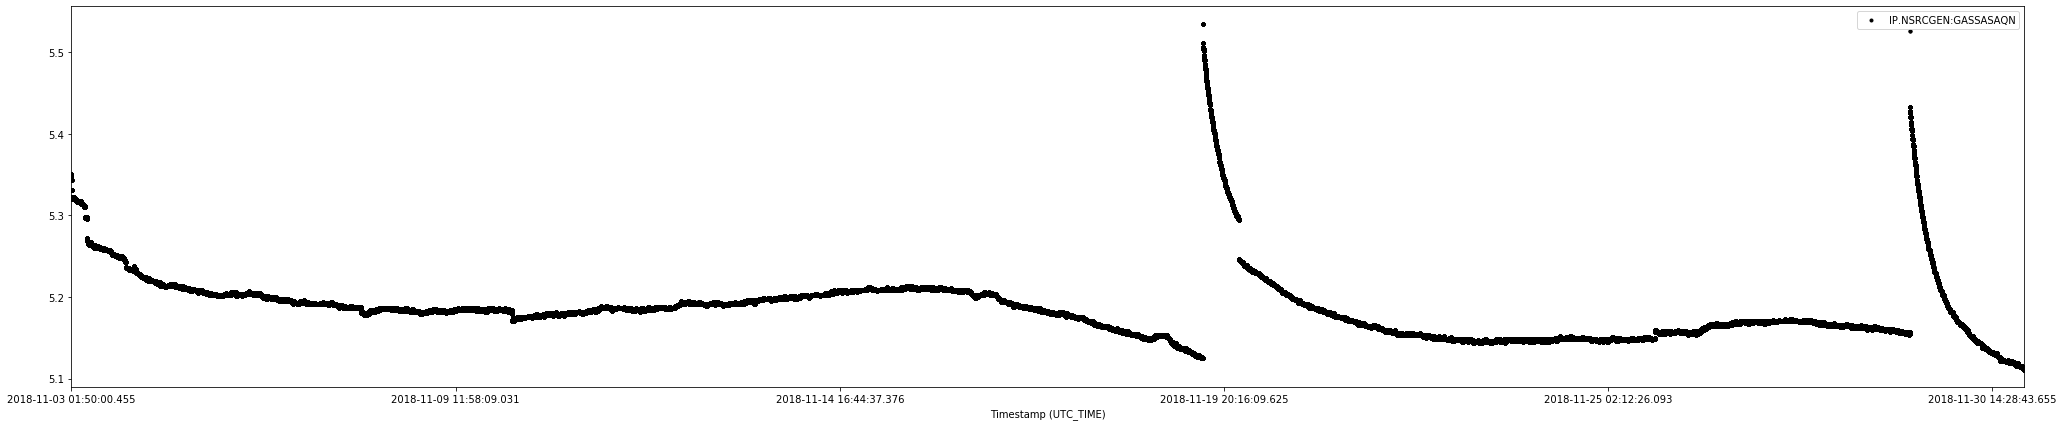

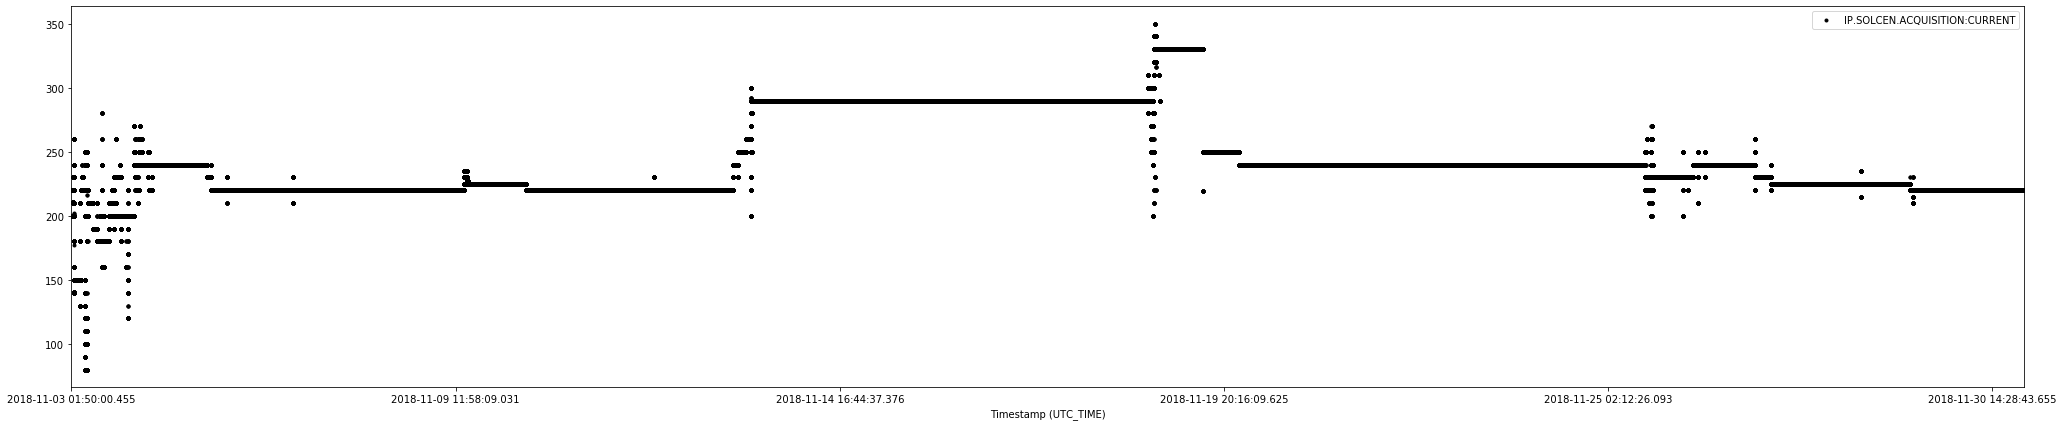

In [11]:
col = 'black'
df.plot(style='k.', x='Timestamp (UTC_TIME)', y='ITF.BCT25:CURRENT', c=col)
df.plot(style='k.', x='Timestamp (UTC_TIME)', y='ITF.BCT25:CURRENT_VAR', c=col)
df.plot(style='k.', x='Timestamp (UTC_TIME)', y='IS_STABLE', c=col)

df.plot(style='k.', x='Timestamp (UTC_TIME)', y='IP.NSRCGEN:BIASDISCAQNV', c=col)
df.plot(style='k.', x='Timestamp (UTC_TIME)', y='IP.NSRCGEN:GASSASAQN', c=col)
df.plot(style='k.', x='Timestamp (UTC_TIME)', y='IP.SOLCEN.ACQUISITION:CURRENT', c=col)

In [13]:
cols_to_cluster = ['IP.NSRCGEN:BIASDISCAQNV', 'IP.NSRCGEN:GASSASAQN', 'IP.SOLCEN.ACQUISITION:CURRENT']
X = df[cols_to_cluster].values

### Normalization
The First step is to normalize the data. This means to center it to mean 0 and variance 1. This way, all features have the same impact and the standard euclidean metric can be applied.

In [49]:
scaler = StandardScaler()

In [50]:
X_norm = scaler.fit_transform(X)
X_norm

array([[-1.81931618, -0.01601361, -0.87852869],
       [-1.81931618, -0.01601361, -0.87852869],
       [-1.81931618, -0.01601361, -0.87852869],
       ...,
       [ 0.31772923, -0.86370318,  1.19677978],
       [ 0.31772923, -0.86370318,  1.19677978],
       [ 0.31772923, -0.86370318,  1.19677978]])

### K-Means

In [51]:
kmeans = MiniBatchKMeans(n_clusters=5, max_iter=30, verbose=True, batch_size=10000)
result = kmeans.fit_predict(X_norm)

Init 1/3 with method: k-means++
Inertia for init 1/3: 8250.418057
Init 2/3 with method: k-means++
Inertia for init 2/3: 10584.717181
Init 3/3 with method: k-means++
Inertia for init 3/3: 9951.456860
Minibatch iteration 1/2850: mean batch inertia: 0.280676, ewa inertia: 0.280676 
Minibatch iteration 2/2850: mean batch inertia: 0.297137, ewa inertia: 0.281023 
Minibatch iteration 3/2850: mean batch inertia: 0.279214, ewa inertia: 0.280985 
Minibatch iteration 4/2850: mean batch inertia: 0.269198, ewa inertia: 0.280736 
Minibatch iteration 5/2850: mean batch inertia: 0.281944, ewa inertia: 0.280762 
Minibatch iteration 6/2850: mean batch inertia: 0.265672, ewa inertia: 0.280444 
Minibatch iteration 7/2850: mean batch inertia: 0.267378, ewa inertia: 0.280169 
Minibatch iteration 8/2850: mean batch inertia: 0.254341, ewa inertia: 0.279625 
Minibatch iteration 9/2850: mean batch inertia: 0.266180, ewa inertia: 0.279342 
Minibatch iteration 10/2850: mean batch inertia: 0.267821, ewa inertia: 

In [52]:
df['KMEANS_RESULT'] = result

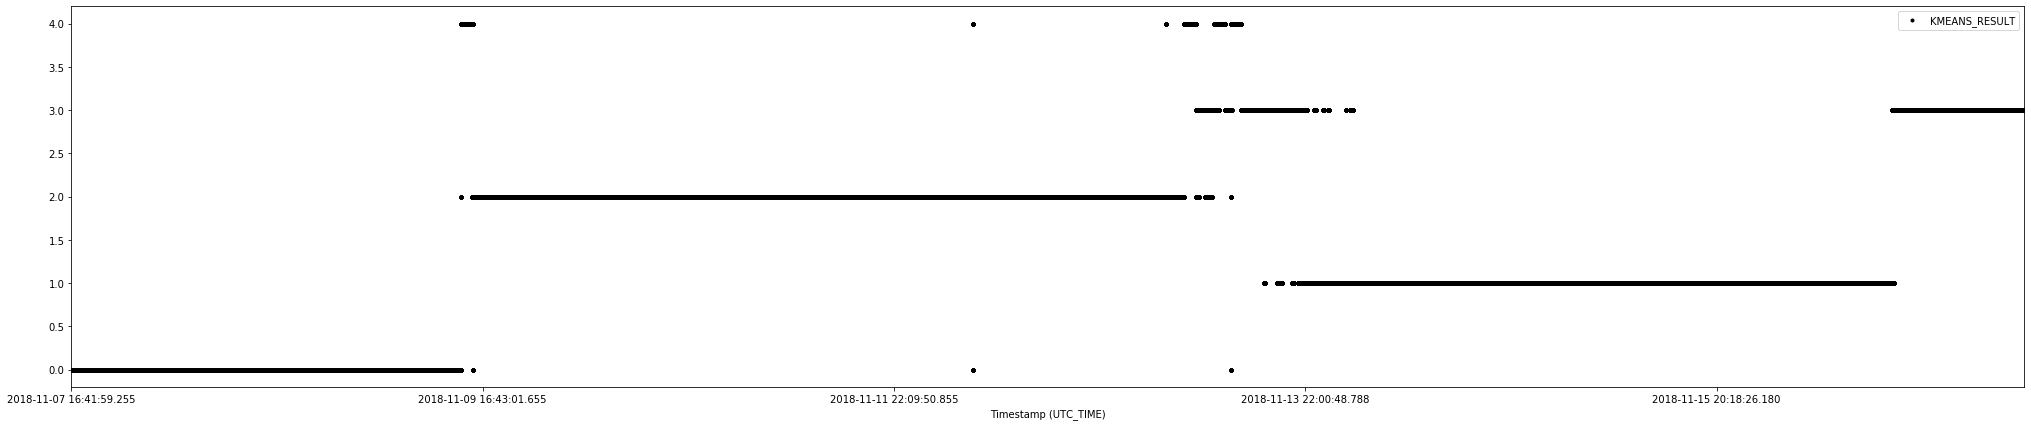

In [53]:
df.plot(style='k.', x='Timestamp (UTC_TIME)', y='KMEANS_RESULT', c='black')

Here we can see into which clusters the data was grouped.

In [54]:
df.groupby('KMEANS_RESULT').describe()

,IP.NSRCGEN:BIASDISCAQNV,IP.NSRCGEN:GASSASAQN,IP.SOLCEN.ACQUISITION:CURRENT
0,-257.646632,5.185080,220.017271
1,-237.490246,5.206358,290.007917
2,-237.520155,5.184669,221.574029
3,-237.318114,5.191479,287.433089
4,-211.858594,5.191514,252.600709


The resulting cluster center.

### DBSCAN

First, we will define a weighted euclidean metric, such that the epsilon value can be applied without prefering one particular dimension. This time we will not use rescaled data, to be able to set the parameters according to expert knowledge.
The desired resolutions are:
* IP.NSRCGEN:BIASDISCAQNV: 1 V
* IP.NSRCGEN:GASSASAQN: 1 mV
* IP.SOLCEN.ACQUISITION:CURRENT: 100 mV

In [14]:
def euclidean_weighted_metric(x, y):
    biasDiff = x[0] - y[0] # IP.NSRCGEN:BIASDISCAQNV
    gasDiff = x[1] - y[1] # IP.NSRCGEN:GASSASAQN
    solCenDiff = x[2] - y[2] # IP.SOLCEN.ACQUISITION:CURRENT
    return np.sqrt(biasDiff * biasDiff +
            1000000 * gasDiff * gasDiff +
            100 * solCenDiff * solCenDiff)

In [ ]:
dbscan = DBSCAN(eps=1, min_samples=100, metric=euclidean_weighted_metric)
result = dbscan.fit_predict(X[0:100000, :])

In [ ]:
df['DBSCAN_RESULT'] = [result[i] if i < len(result) else np.nan for i in range(len(df.index))]

Now we need to extract the information of the clusters

In [ ]:
df[cols_to_cluster + ['DBSCAN_RESULT']].groupby('DBSCAN_RESULT').describe()